In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage import color
from skimage.transform import ProjectiveTransform, warp
from harris import harris
from scipy.spatial import distance
import cv2
import random
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D


In [2]:
NUM_MATCH = 50  # number of the points to match
threshold = 0.75

In [3]:
def domatch(gray_img1,gray_img2):
    # detect keypoints and draw 
    sift = cv2.xfeatures2d.SIFT_create()
    
    # compute descriptors
    kp1,des1 = sift.detectAndCompute(gray_img1,None)
    kp2,des2 = sift.detectAndCompute(gray_img2,None)
    kp1 = np.array(kp1)
    kp2 = np.array(kp2)
#     print(np.array(kp1).shape)
#     print(np.array(des1).shape)
#     print(len(kp1))
#     print(len(kp2))
    
    kp_img1=cv2.drawKeypoints(gray_img1,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(1)
    plt.imshow(kp_img1)
    plt.show()
    kp_img2=cv2.drawKeypoints(gray_img2,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(2)
    plt.imshow(kp_img2)
    plt.show()
    
    # do the match
    des_dist = distance.cdist(des1,des2,'sqeuclidean')
#     Shape of des_dist should be (len(kp1),len(kp2))
#     print(len(des_dist[0]))
#     print(len(des_dist))
#     Firstly, sort the des_dist, return the indexes of smallest descriptor distances.
    tmp = np.argsort(des_dist,axis=None)
    match_idx = np.unravel_index(tmp,(len(kp1), len(kp2))) 
#     print(np.array(match_idx).shape)
    match_idx1 = match_idx[0][:NUM_MATCH]
    match_idx2 = match_idx[1][:NUM_MATCH]
    match1, match2 = kp1[match_idx1], kp2[match_idx2]
    return match1,match2
    
    


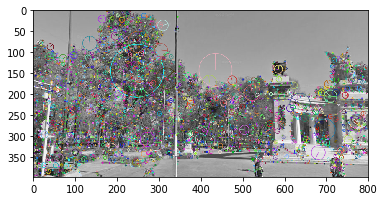

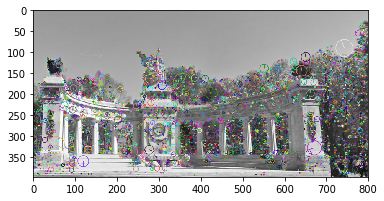

In [4]:
%matplotlib inline
filename1 = 'left.JPG'
filename2 = 'right.JPG'
orig_img1 = mpimg.imread(filename1)
orig_img2 = mpimg.imread(filename2)
grayimg1 = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2GRAY)
grayimg2 = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2GRAY)
img1 = grayimg1.astype(np.float32)/255.0
img2 = grayimg2.astype(np.float32)/255.0
match1,match2 = domatch(grayimg1,grayimg2)

tmp1 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match1]   
tmp2 = [(int(kp.pt[0]), int(kp.pt[1])) for kp in match2]
coord1 = np.asarray(tmp1)
coord2 = np.asarray(tmp2)
match_coords = np.concatenate((coord1, coord2), axis=1)



In [5]:
def fit_homography(select_pairs1,select_pairs2):
    A = np.zeros((8, 9))
    for i in range(4):
        pt1, pt2 = select_pairs1[i], select_pairs2[i]
        xi = np.array([pt1[0], pt1[1], 1])
        y_xi = -pt2[1] * xi
        x_xi = -pt2[0] * xi
        A[2*i, 3:6] = xi
        A[2*i, 6:9] = y_xi
        A[2*i+1, 0:3] = xi
        A[2*i+1, 6:9] = x_xi
    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3,3)
    H = H / H[2, 2] 
    return H

In [6]:
def get_errors(match_coords, H):
    num_pairs = len(match_coords)
    all_p1 = np.concatenate((match_coords[:, 0:2], np.ones((num_pairs, 1))), axis=1)
    all_p2 = match_coords[:, 2:4]

    # Transform every point in p1 to estimate p2.
    estimate_p2 = np.zeros((num_pairs, 2))
    for i in range(num_pairs):
        temp = np.matmul(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2]
    # Compute error.
    errors = np.linalg.norm(all_p2 - estimate_p2, axis=1) ** 2
    return errors

In [7]:
def RANSAC(match_coords,threshold):
    max_num = 2000
    count = 0
    inlier_num = 0
    num_best_inliers = 0
    while count < max_num:
        rand_idx = random.sample(range(coord1.shape[0]), k=4)
        select_pairs1 = coord1[rand_idx]
        select_pairs2 = coord2[rand_idx]
        
        H = fit_homography(select_pairs1,select_pairs2)
        if np.linalg.matrix_rank(H) < 3:
            continue
        errors = get_errors(match_coords, H)
        idx = np.where(errors < threshold)[0]
        inliers = match_coords[idx]
        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H
            avg_residual = errors[idx].sum() / num_best_inliers
        count += 1
    best_inliers = np.array(best_inliers)
    return best_inliers, best_H, avg_residual

In [8]:
def warpTwoImages(img1, img2, H):
    """
    warp img2 to img1 with homograph H
    Reference: https://stackoverflow.com/questions/13063201/how-to-show-the-
               whole-image-when-using-opencv-warpperspective
    """
    grayscale = len(img1.shape) == 2
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]    # t = (x,y) = (643, 185), top-left coord of img2
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]]) # translate
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))    # (h, w)
    
    # Average overlapping area
    if grayscale:
        for y in range(h1):
            for x in range(w1):
                if t[0]+x < result.shape[1] and t[1]+y < result.shape[0]:
                    if result[t[1]+y, t[0]+x] == 0:
                        result[t[1]+y, t[0]+x] = img1[y, x]
                    else:
                        result[t[1]+y, t[0]+x] = result[t[1]+y, t[0]+x] / 2 + img1[y, x] / 2
    else:
        for y in range(h1):
            for x in range(w1):
                if t[0]+x < result.shape[1] and t[1]+y < result.shape[0]:
                    if np.count_nonzero(result[t[1]+y, t[0]+x]) == 0:
                        result[t[1]+y, t[0]+x, :] = img1[y, x, :]
                    else:
                        result[t[1]+y, t[0]+x, 0] = result[t[1]+y, t[0]+x, 0] / 2 + img1[y, x, 0] / 2
                        result[t[1]+y, t[0]+x, 1] = result[t[1]+y, t[0]+x, 1] / 2 + img1[y, x, 1] / 2
                        result[t[1]+y, t[0]+x, 2] = result[t[1]+y, t[0]+x, 2] / 2 + img1[y, x, 2] / 2

    return result


In [9]:
def plot_inlier_matches(inliers, grayimg1, grayimg2):
    left = Image.open('left.JPG').convert('L')
    right = Image.open('right.JPG').convert('L')
    combine = np.zeros((left.size[1], left.size[0]*2))
    combine[:,:left.size[0]] = left
    combine[:,left.size[0]:] = right
    fig, ax = plt.subplots(figsize=(12, 8))
#     plt.figure(figsize=(12, 8))
    ax.set_aspect('equal')
    ax.imshow(np.array(combine).astype(float), cmap='gray')
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2]+left.size[0], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2]+left.size[0]],[inliers[:,1], inliers[:,3]], 
            'r', linewidth=0.4)
    plt.axis('off')
    # plt.savefig(root+'outputs/inlier_matches.svg', format='svg')
    plt.show()

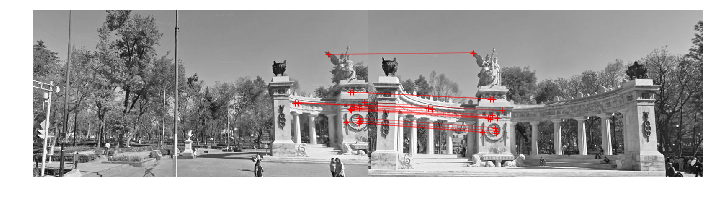

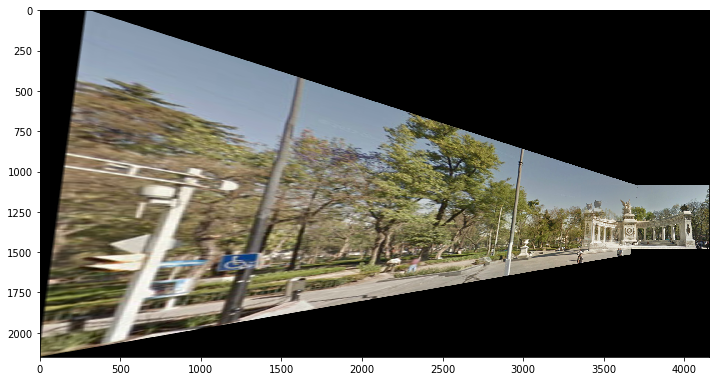

inliers number is: 16
average residual is: 0.27685615824839194


In [10]:
inliers, H, avg_residual = RANSAC(match_coords, threshold)
plot_inlier_matches(inliers.astype(int), grayimg1, grayimg2)
stitched = warpTwoImages(orig_img2,orig_img1,H)
plt.figure(figsize=(12, 8))
# plt.figure(figsize=(12, 8))
plt.imshow(stitched)
plt.show()
print('inliers number is:',len (inliers))
print('average residual is:',avg_residual)